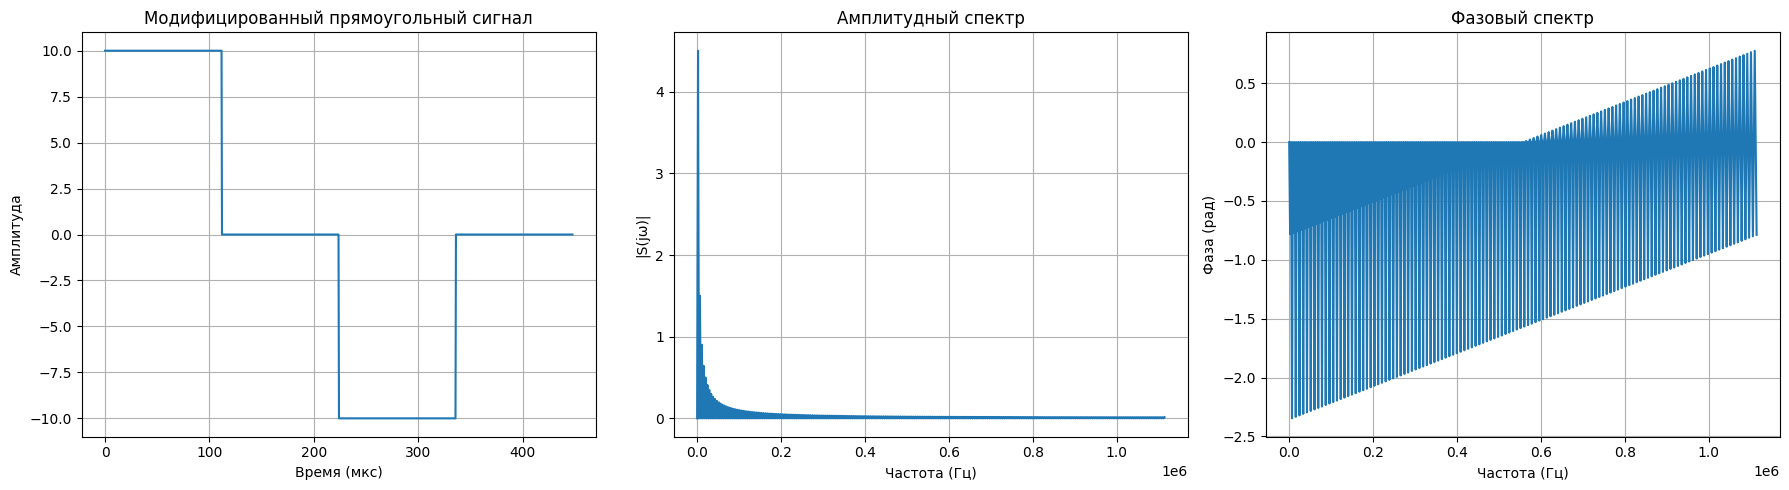

Ширина спектра с учетом потерь энергии:
Потери 10%: 6696 Гц
Потери 5%: 20089 Гц
Потери 2%: 46875 Гц
Потери 1%: 91518 Гц
Потери 0.1%: 645089 Гц


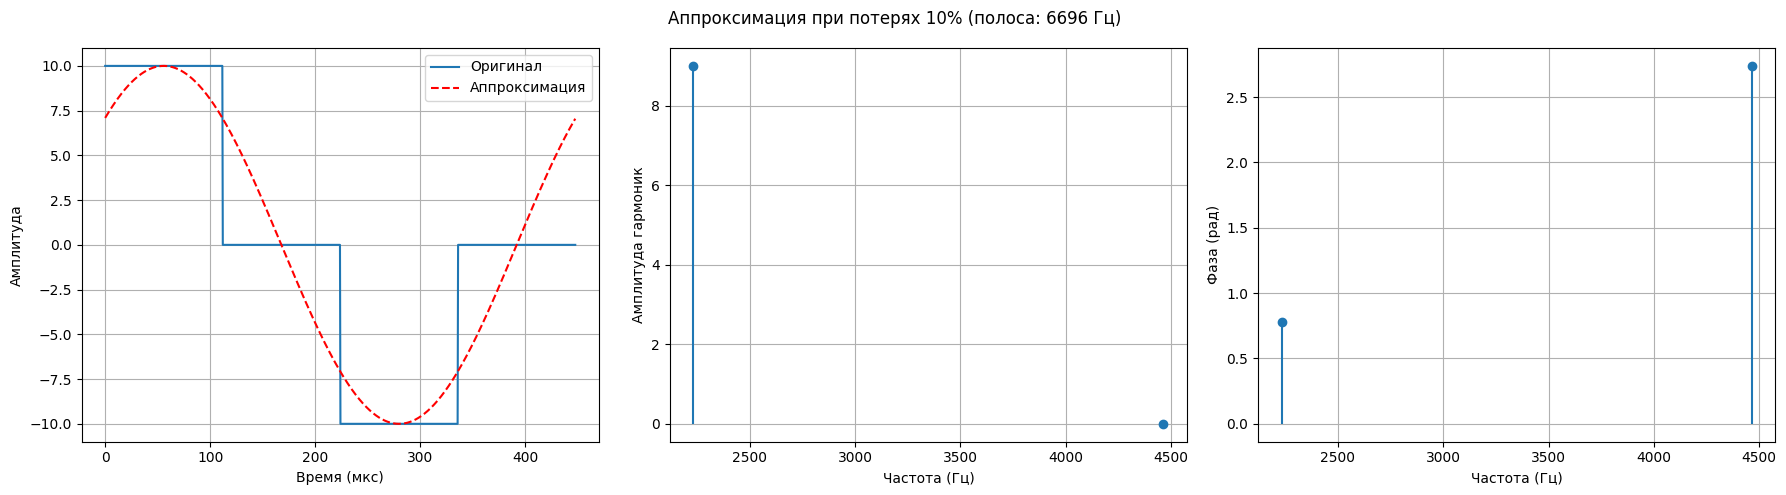

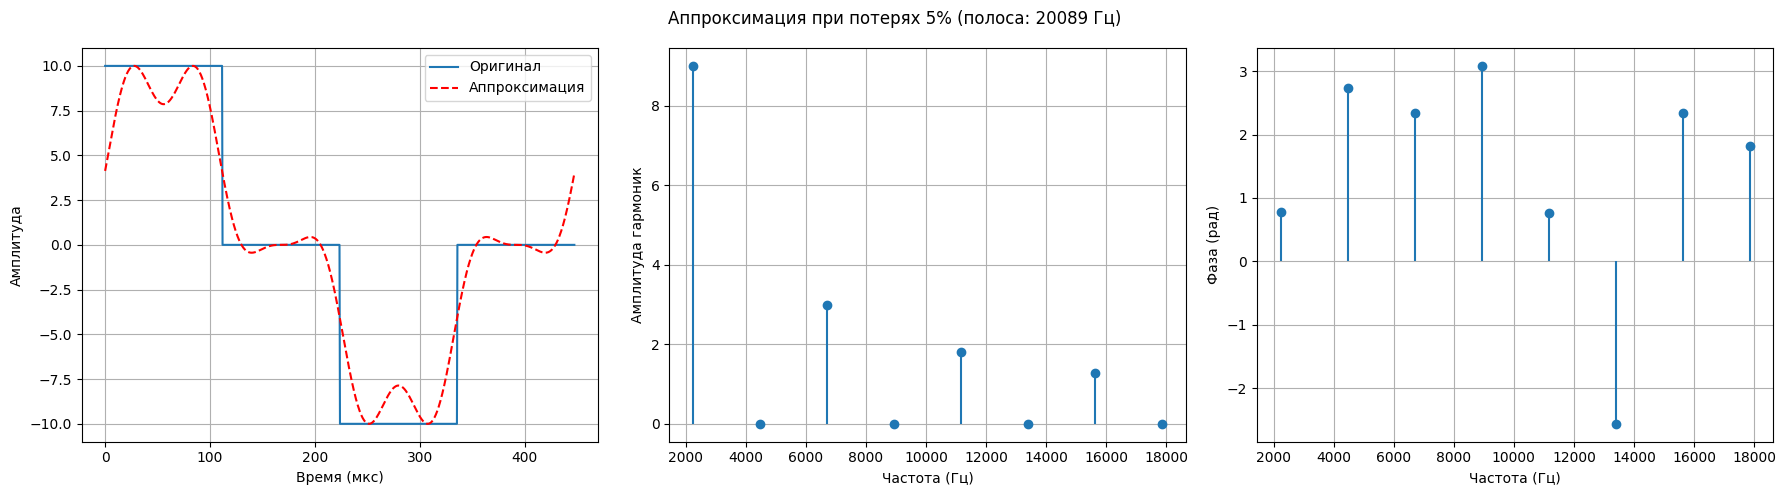

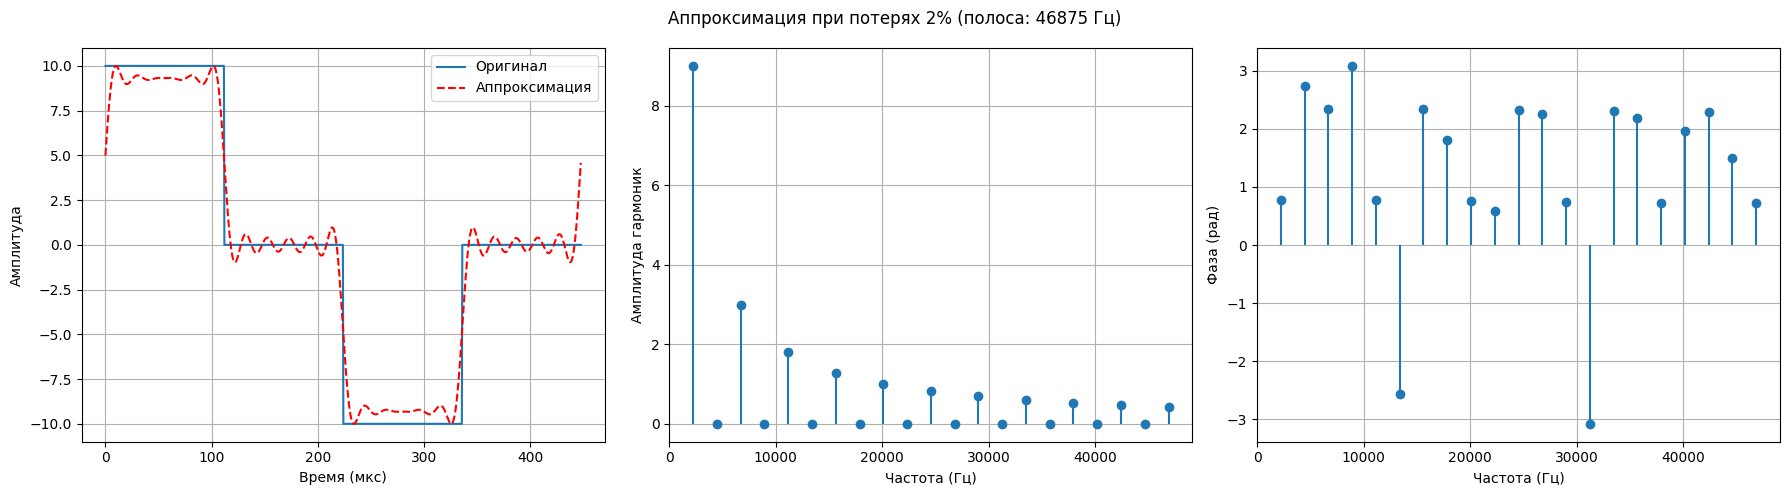

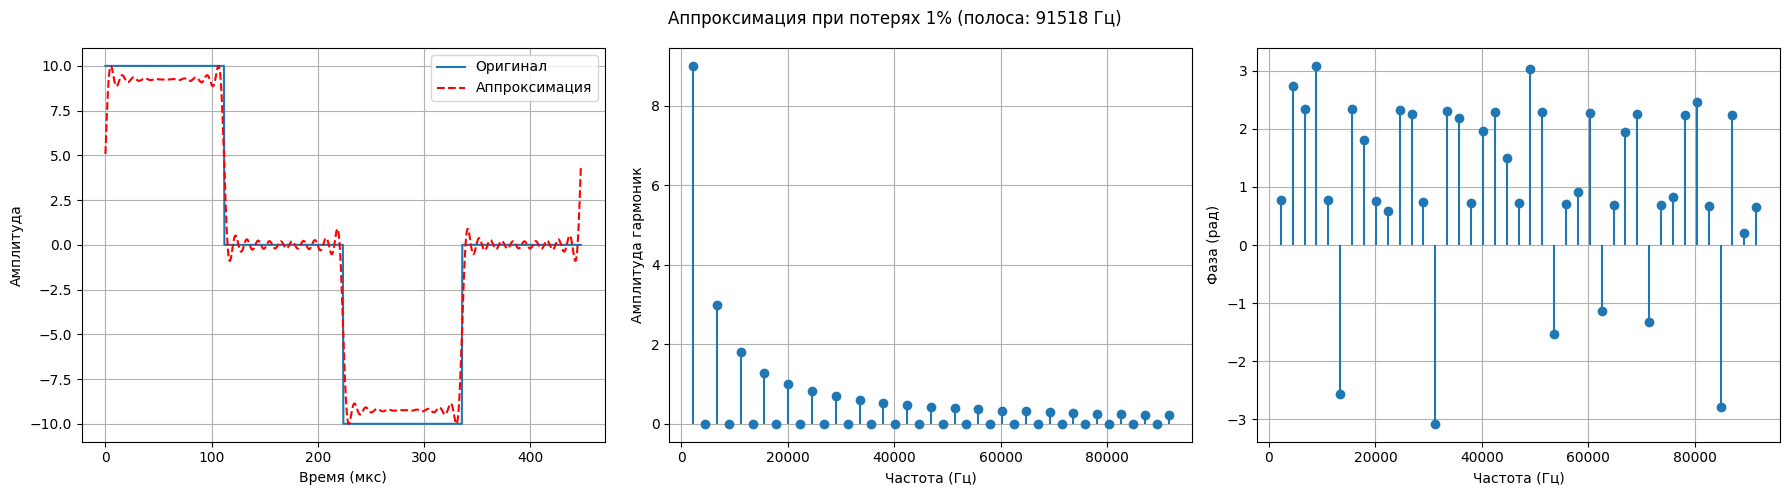

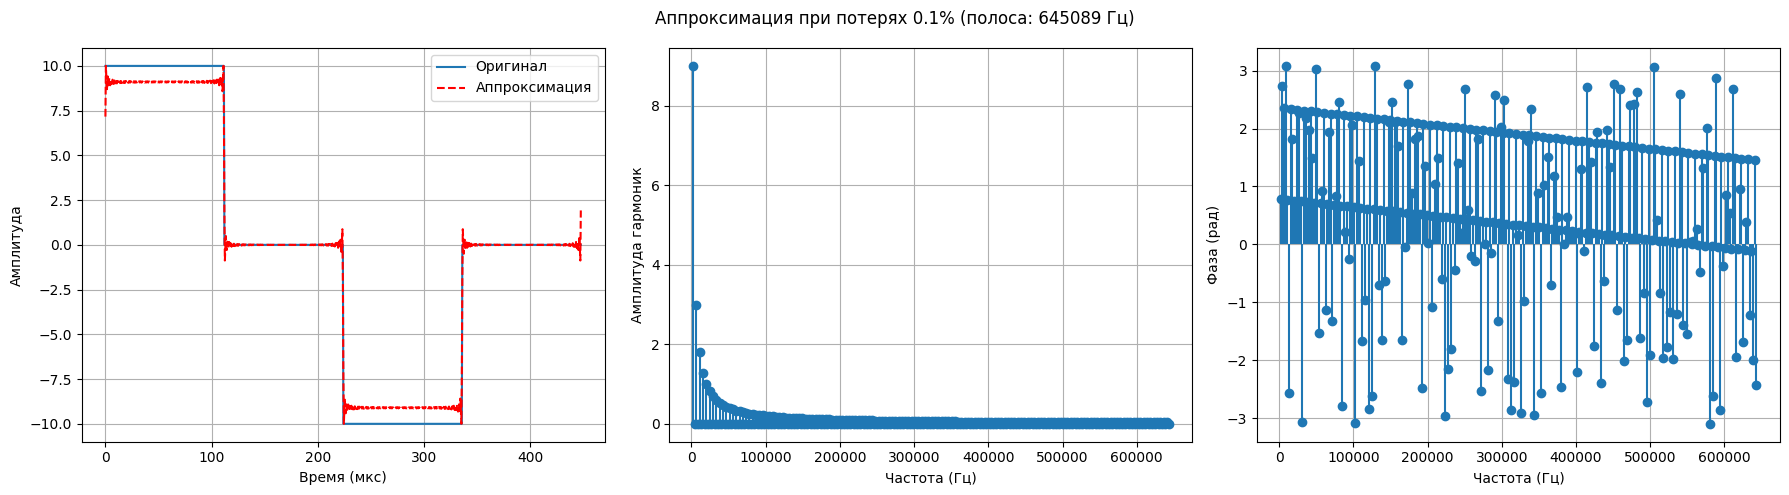

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq

# Параметры сигнала
T = 448e-6  # Полный период
Emax = 10    # Амплитуда

# Функция генерации сигнала
def rectangular_signal(x):
    x = x % T  # Нормализация времени
    quarter = T / 4

    if 0 <= x < quarter:
        return Emax
    elif quarter <= x < 2 * quarter:
        return 0
    elif 2 * quarter <= x < 3 * quarter:
        return -Emax
    else:
        return 0

# Расчет временной оси
N = 1000
t = np.linspace(0, T, N, endpoint=False)
dt = t[1] - t[0]
fs = 1 / dt

# Генерация сигнала
signal = np.vectorize(rectangular_signal)(t)  # Векторизация функции

# Расчет БПФ
S = fft(signal)
frequencies = fftfreq(N, dt)
positive_freqs = frequencies[:N//2]
S_positive = S[:N//2]

# Нормировка спектров
amplitude_spectrum = np.abs(S_positive) / N
phase_spectrum = np.angle(S_positive)

# Визуализация исходных данных
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(t*1e6, signal)
plt.title("Модифицированный прямоугольный сигнал")
plt.xlabel("Время (мкс)")
plt.ylabel("Амплитуда")
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(positive_freqs, amplitude_spectrum)
plt.title("Амплитудный спектр")
plt.xlabel("Частота (Гц)")
plt.ylabel("|S(jω)|")
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(positive_freqs, phase_spectrum)
plt.title("Фазовый спектр")
plt.xlabel("Частота (Гц)")
plt.ylabel("Фаза (рад)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Расчет энергетических характеристик (аналогично исходному коду)
E_s_time = np.sum(np.abs(signal)**2) * dt
energy_per_bin = (np.abs(S_positive)**2) * (dt/N)
cumulative_energy = np.cumsum(energy_per_bin)
E_s_freq = cumulative_energy[-1]
normalized_cumulative_energy = cumulative_energy / E_s_freq

# Определение ширины спектра
loss_percentage = [10, 5, 2, 1, 0.1]
w_final = []

for loss in loss_percentage:
    idx = np.where((1 - normalized_cumulative_energy)*100 <= loss)[0]
    w_final.append(round(positive_freqs[idx[0]]) if len(idx)>0 else None)

print("Ширина спектра с учетом потерь энергии:")
for loss, width in zip(loss_percentage, w_final):
    print(f"Потери {loss}%: {width or '--'} Гц")

# Функции для расчета коэффициентов Фурье
def a_n(n, T):
    integral = np.sum(signal * np.cos(2*np.pi*n*t/T)) * dt
    return (2/T) * integral

def b_n(n, T):
    integral = np.sum(signal * np.sin(2*np.pi*n*t/T)) * dt
    return (2/T) * integral

# Процедура аппроксимации
for loss, bandwidth in zip(loss_percentage, w_final):
    if not bandwidth: continue

    # Количество гармоник
    n_max = int(bandwidth * T)

    # Расчет коэффициентов
    a0 = a_n(0, T)/2
    a_coeffs = [a_n(n, T) for n in range(1, n_max+1)]
    b_coeffs = [b_n(n, T) for n in range(1, n_max+1)]

    # Восстановление сигнала
    reconstructed = a0 + sum(
        a*np.cos(2*np.pi*n*t/T) + b*np.sin(2*np.pi*n*t/T)
        for n, (a, b) in enumerate(zip(a_coeffs, b_coeffs), 1)
    )

    # Нормировка амплитуды
    reconstructed *= Emax / np.max(np.abs(reconstructed))

    # Визуализация
    fig, ax = plt.subplots(1, 3, figsize=(18,5))
    fig.suptitle(f"Аппроксимация при потерях {loss}% (полоса: {bandwidth} Гц)")

    # Временная область
    ax[0].plot(t*1e6, signal, label="Оригинал")
    ax[0].plot(t*1e6, reconstructed, 'r--', label="Аппроксимация")
    ax[0].set_xlabel("Время (мкс)")
    ax[0].set_ylabel("Амплитуда")
    ax[0].legend()
    ax[0].grid(True)

    # Спектральная амплитуда
    ax[1].stem(
        np.arange(1, n_max+1)/T,
        np.sqrt(np.array(a_coeffs)**2 + np.array(b_coeffs)**2),
        basefmt=" "
    )
    ax[1].set_xlabel("Частота (Гц)")
    ax[1].set_ylabel("Амплитуда гармоник")
    ax[1].grid(True)

    # Фазовая характеристика
    ax[2].stem(
        np.arange(1, n_max+1)/T,
        np.arctan2(np.array(b_coeffs), np.array(a_coeffs)),
        basefmt=" "
    )
    ax[2].set_xlabel("Частота (Гц)")
    ax[2].set_ylabel("Фаза (рад)")
    ax[2].grid(True)

    plt.tight_layout()
    plt.show()
